<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Model Optimization (MO) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">Required Imports</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Package Descriptions</h3>
<ul style="font-family: 'Arial', sans-serif;">
    <li><strong>pandas</strong>: For data manipulation and analysis, enabling easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: To create data visualizations and plots.</li>
    <li><strong>seaborn</strong>: For generating attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand data quality.</li>
</ul>


In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
import sys # type: ignore
import os # type: ignore

from scipy import stats # type: ignore
from scipy.stats import mode
from sklearn.model_selection import train_test_split # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from keras.utils import to_categorical


sys.path.append(os.path.abspath("../utils"))
from meta_model_train import meta_model_catboost, meta_model_rf, meta_model_xgbc, meta_model_et, meta_model_lr, meta_model_gb
from neural_network import neural_network
from plots import plot_training_history, plot_confusion_matrix
from predicitons_csv import save_predictions_to_csv, save_predictions_to_csv_ar
from save_models import save_model

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section handles loading the dataset into the environment for further processing. Using <strong>pandas</strong>, we load the data into a structured dataframe, allowing for easy manipulation, exploration, and analysis throughout the project.
</p>


In [3]:
path = "../data/"

data_train_FS = pd.read_csv(path + "data_train_post_FS.csv")
data_test_FS = pd.read_csv(path + "data_test_post_FS.csv")

combined_data = pd.concat([data_train_FS, data_test_FS], keys=['train', 'test'])

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Model Selection
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section focuses on selecting the best-performing models for predicting workers' compensation claims outcomes. Various machine learning algorithms are evaluated based on their accuracy, interpretability, and suitability for the dataset, ensuring an optimal balance between predictive performance and computational efficiency.
</p>


In [ ]:
data_test = data_test_FS.drop(['Claim Identifier', 'Claim Injury Type', 'Agreement Reached', 'WCB Decision'], axis=1)
x_FS = data_train_FS.drop(['Claim Identifier', 'Claim Injury Type', 'Agreement Reached', 'WCB Decision'], axis=1)
y_FS = data_train_FS['Claim Injury Type']

X_train_FS, X_val_FS, y_train_FS, y_val_FS = train_test_split(x_FS, y_FS, test_size=0.25)

In [5]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_FS, y_train_FS)

  File "d:\Repositories\TGNTG_ML\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1420, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [6]:
def meta_model_run(model, X_train_resampled=None, y_train_resampled=None, data_test_FS=None, n_splits=5):
    if X_train_resampled is None or y_train_resampled is None or data_test_FS is None:
        raise ValueError("Os dados de treinamento e teste precisam ser fornecidos.")

    data_test = data_test_FS.drop(columns=['Claim Identifier', 'Claim Injury Type'])

    if model == "CatBoost":
        models, f1_scores, oof_predictions, test_predictions = meta_model_catboost(
            X_train_resampled, y_train_resampled, data_test, n_splits_n=n_splits
        )
    elif model == "RandomForest":
        models, f1_scores, oof_predictions, test_predictions = meta_model_rf(
            X_train_resampled, y_train_resampled, data_test, n_splits_n=n_splits
        )
    elif model == "XGBoost":
        models, f1_scores, oof_predictions, test_predictions = meta_model_xgbc(
            X_train_resampled, y_train_resampled, data_test, n_splits_n=n_splits
        )
    elif model == "ExtraTree":
        models, f1_scores, oof_predictions, test_predictions = meta_model_et(
            X_train_resampled, y_train_resampled, data_test, n_splits_n=n_splits
        )
    else:
        raise ValueError("Modelo inválido. Escolha entre 'CatBoost', 'RandomForest', 'XGBoost' ou 'ExtraTree'.")

    return oof_predictions, test_predictions


<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 32px; text-shadow: 2px 2px #D1D1D1;">Claim Injury Type Prediction(Without Agreement Reached and WCB Decision)</h3>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">CatBoost Classifier</h3>

In [10]:
#oof_predictions, test_predictions = meta_model_run(
#    model="CatBoost",
#    X_train_resampled=X_train_resampled,
#    y_train_resampled=y_train_resampled,
#    data_test_FS=data_test_FS
#)


In [11]:
#nn_model, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions, y_train_resampled)

#history = nn_model.fit(
#    X_nn_train, y_nn_train,
#    validation_data=(X_nn_val, y_nn_val),
#    epochs=10,
#    batch_size=64,
#    callbacks=[early_stopping, reduce_lr],
#    verbose=1
#)

In [12]:
#plot_training_history(history)

In [13]:
#plot_confusion_matrix(model=nn_model, X_val=X_nn_val, y_val=y_nn_val,
#    class_mapping={
#        0: '2. NON-COMP',
#        1: '4. TEMPORARY',
#       2: '3. MED ONLY',
#        3: '5. PPD SCH LOSS',
#        4: '6. PPD NSL',
#        5: '1. CANCELLED',
#        6: '8. DEATH',
#        7: '7. PTD'
#    }, title="Matriz de Confusão - Conjunto de Validação"
#)

In [14]:
#save_predictions_to_csv(
#    model=nn_model,
#    test_data=test_predictions,
#    claim_ids=data_test_FS["Claim Identifier"],
#    class_mapping={
#       0: '2. NON-COMP',
#        1: '4. TEMPORARY',
#        2: '3. MED ONLY',
#        3: '5. PPD SCH LOSS',
#        4: '6. PPD NSL',
#        5: '1. CANCELLED',
#        6: '8. DEATH',
#        7: '7. PTD'
#    },
#    output_path="../predictions/group_40_KFold_CatBoost_NN_predictions.csv"
#)


In [15]:
#predicitons_data = pd.read_csv('../predictions/group_40_KFold_CatBoost_NN_predictions.csv')
#values = predicitons_data['Claim Injury Type'].value_counts()
#values

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Random Forest Classifier</h3>

In [16]:
oof_predictions_rf, test_predictions_rf = meta_model_run(
    model="RandomForest",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test_FS,
    n_splits=5
)

Training Fold 1...
Macro F1-Score do Fold 1: 0.9158
Training Fold 2...
Macro F1-Score do Fold 2: 0.9168
Training Fold 3...
Macro F1-Score do Fold 3: 0.9166
Training Fold 4...
Macro F1-Score do Fold 4: 0.9161
Training Fold 5...
Macro F1-Score do Fold 5: 0.9156
Treinamento concluído em 41.94 minutos.


In [74]:
nn_model_rf, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_rf, y_train_resampled)

history = nn_model_rf.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_rf, "RF_NN_model")

Epoch 1/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9147 - loss: 0.2565 - val_accuracy: 0.9254 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 2/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9218 - loss: 0.2258 - val_accuracy: 0.9257 - val_loss: 0.2070 - learning_rate: 0.0010
Epoch 3/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.9226 - loss: 0.2224 - val_accuracy: 0.9260 - val_loss: 0.2057 - learning_rate: 0.0010
Epoch 4/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9233 - loss: 0.2195 - val_accuracy: 0.9262 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 5/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.9232 - loss: 0.2197 - val_accuracy: 0.9266 - val_loss: 0.2041 - learning_rate: 0.0010
Epoch 6/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.9229 - loss: 0.2207 - val_accuracy: 0.9263 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 7/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step -

'../models/RF_NN_model.pkl'

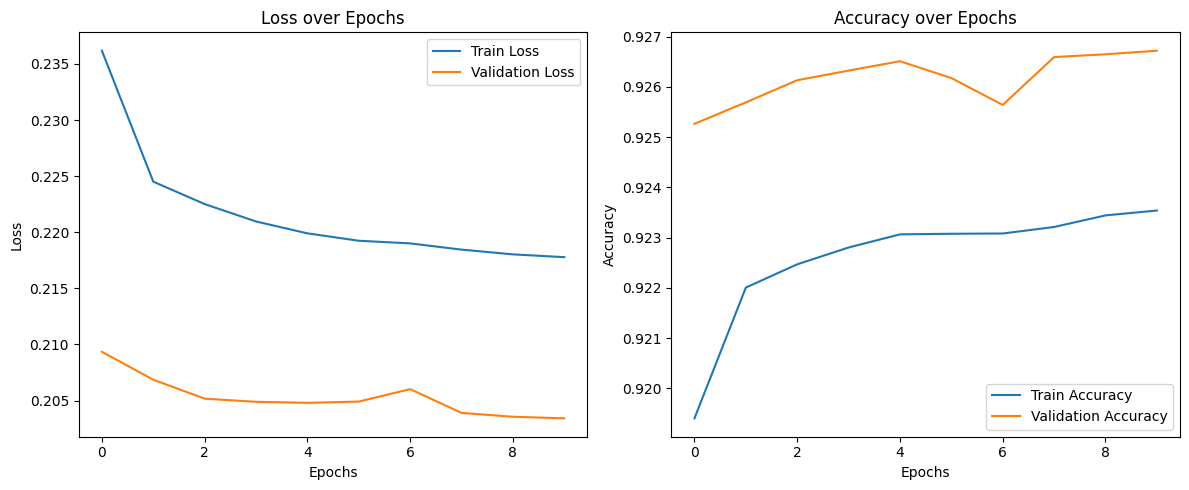

In [18]:
plot_training_history(history)

10915/10915 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


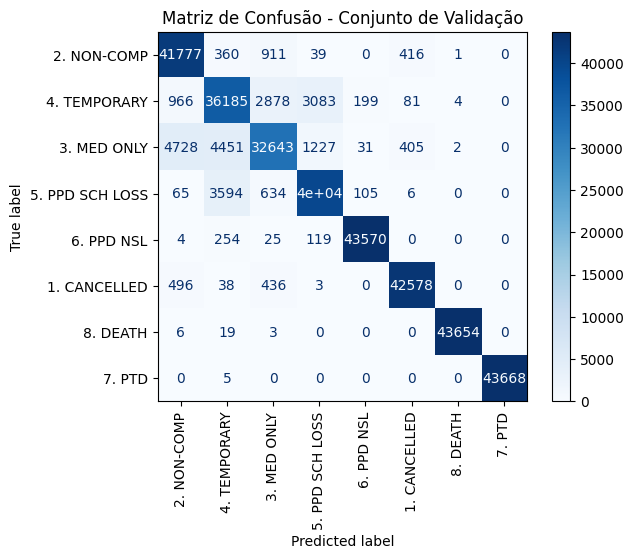

                 precision    recall  f1-score   support

    2. NON-COMP       0.87      0.96      0.91     43504
   4. TEMPORARY       0.81      0.83      0.82     43396
    3. MED ONLY       0.87      0.75      0.81     43487
5. PPD SCH LOSS       0.90      0.90      0.90     43996
     6. PPD NSL       0.99      0.99      0.99     43972
   1. CANCELLED       0.98      0.98      0.98     43551
       8. DEATH       1.00      1.00      1.00     43682
         7. PTD       1.00      1.00      1.00     43673

       accuracy                           0.93    349261
      macro avg       0.93      0.93      0.93    349261
   weighted avg       0.93      0.93      0.93    349261



In [ ]:
plot_confusion_matrix(model=nn_model_rf, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    }, title="Matriz de Confusão - Conjunto de Validação"
)

In [ ]:
save_predictions_to_csv(
    model=nn_model_rf,
    test_data=test_predictions_rf,
    claim_ids=data_test_FS["Claim Identifier"],
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    },
    output_path="../predictions/group_40_KFold_RF_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Predições salvas em '../predictions/group_40_KFold_RF_NN_predictions.csv'.


In [21]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_RF_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP        312498
4. TEMPORARY        50971
3. MED ONLY         16264
1. CANCELLED         7422
5. PPD SCH LOSS       820
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">XGBoost Classifier</h3>

In [22]:
oof_predictions_xgbc, test_predictions_xgbc = meta_model_run(
    model="XGBoost",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test_FS,
    n_splits=5
)

Training Fold 1...
Macro F1-Score do Fold 1: 0.8866
Training Fold 2...
Macro F1-Score do Fold 2: 0.8878
Training Fold 3...
Macro F1-Score do Fold 3: 0.8875
Training Fold 4...
Macro F1-Score do Fold 4: 0.8883
Training Fold 5...
Macro F1-Score do Fold 5: 0.8861
Treinamento concluído em 47.93 minutos.


In [75]:
nn_model_xgbc, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_xgbc, y_train_resampled)

history = nn_model_xgbc.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_xgbc, "XGBoost_NN_model")

Epoch 1/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.8818 - loss: 0.3418 - val_accuracy: 0.8920 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 2/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.8882 - loss: 0.3071 - val_accuracy: 0.8920 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 3/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.8886 - loss: 0.3047 - val_accuracy: 0.8923 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 4/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.8893 - loss: 0.3020 - val_accuracy: 0.8912 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 5/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 160s 7ms/step - accuracy: 0.8892 - loss: 0.3024 - val_accuracy: 0.8923 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 6/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.8893 - loss: 0.3008 - val_accuracy: 0.8921 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 7/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/ste

'../models/XGBoost_NN_model.pkl'

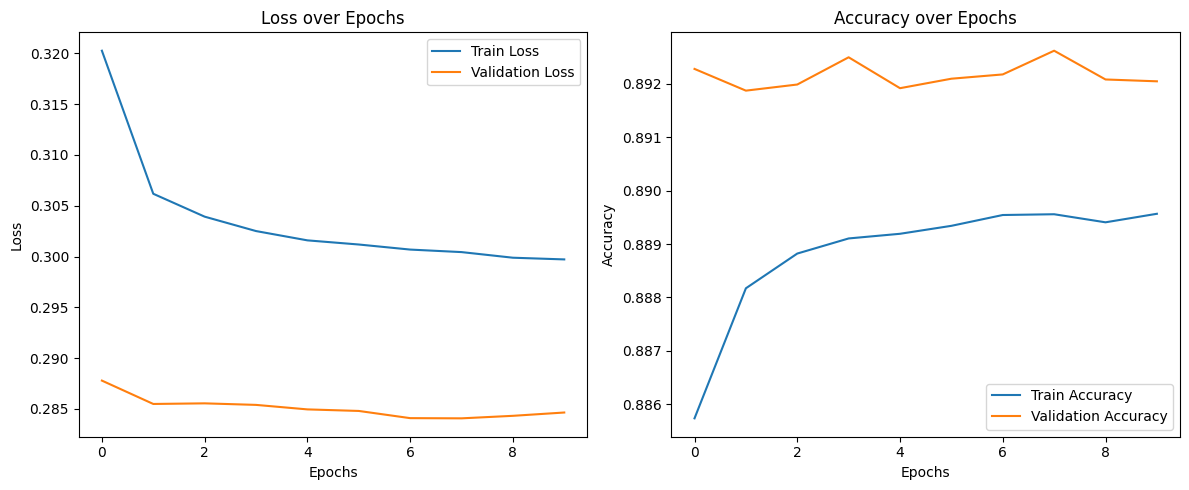

In [24]:
plot_training_history(history)

10915/10915 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


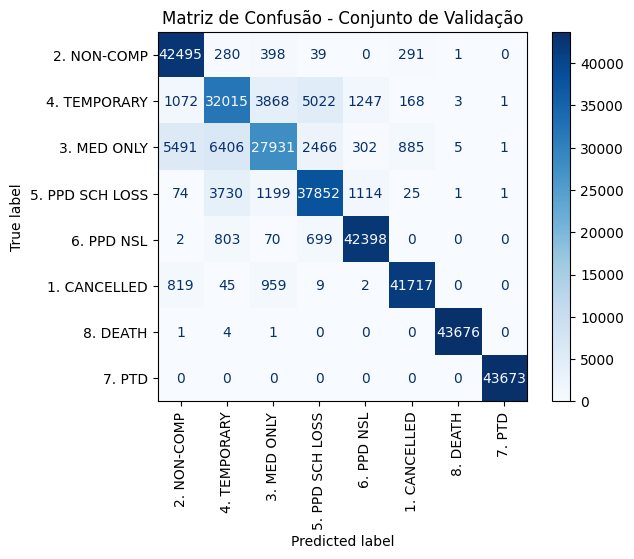

                 precision    recall  f1-score   support

    2. NON-COMP       0.85      0.98      0.91     43504
   4. TEMPORARY       0.74      0.74      0.74     43396
    3. MED ONLY       0.81      0.64      0.72     43487
5. PPD SCH LOSS       0.82      0.86      0.84     43996
     6. PPD NSL       0.94      0.96      0.95     43972
   1. CANCELLED       0.97      0.96      0.96     43551
       8. DEATH       1.00      1.00      1.00     43682
         7. PTD       1.00      1.00      1.00     43673

       accuracy                           0.89    349261
      macro avg       0.89      0.89      0.89    349261
   weighted avg       0.89      0.89      0.89    349261



In [ ]:
plot_confusion_matrix(model=nn_model_xgbc, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    }, title="Matriz de Confusão - Conjunto de Validação"
)

In [ ]:
save_predictions_to_csv(
    model=nn_model_xgbc,
    test_data=test_predictions_xgbc,
    claim_ids=data_test_FS["Claim Identifier"],
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    },
    output_path="../predictions/group_40_KFold_XGBC_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Predições salvas em '../predictions/group_40_KFold_XGBC_NN_predictions.csv'.


In [27]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_XGBC_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP        317462
4. TEMPORARY        43531
3. MED ONLY         19185
1. CANCELLED         6454
5. PPD SCH LOSS      1338
8. DEATH                4
6. PPD NSL              1
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Extra Tree Classifier</h3>

In [28]:
oof_predictions_et, test_predictions_et = meta_model_run(
    model="ExtraTree",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test_FS,
    n_splits=5
)

Training Fold 1...
Macro F1-Score do Fold 1: 0.9287
Training Fold 2...
Macro F1-Score do Fold 2: 0.9289
Training Fold 3...
Macro F1-Score do Fold 3: 0.9291
Training Fold 4...
Macro F1-Score do Fold 4: 0.9288
Training Fold 5...
Macro F1-Score do Fold 5: 0.9285
Treinamento concluído em 42.75 minutos.


In [76]:
nn_model_et, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_et, y_train_resampled)

history = nn_model_et.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_et, "ExtraTree_NN_model")

Epoch 1/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - accuracy: 0.9285 - loss: 0.2178 - val_accuracy: 0.9383 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 2/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - accuracy: 0.9356 - loss: 0.1871 - val_accuracy: 0.9392 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 3/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - accuracy: 0.9361 - loss: 0.1843 - val_accuracy: 0.9394 - val_loss: 0.1696 - learning_rate: 0.0010
Epoch 4/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.9369 - loss: 0.1824 - val_accuracy: 0.9398 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 5/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.9371 - loss: 0.1819 - val_accuracy: 0.9398 - val_loss: 0.1696 - learning_rate: 0.0010
Epoch 6/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - accuracy: 0.9368 - loss: 0.1813 - val_accuracy: 0.9399 - val_loss: 0.1690 - learning_rate: 0.0010
Epoch 7/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/st

'../models/ExtraTree_NN_model.pkl'

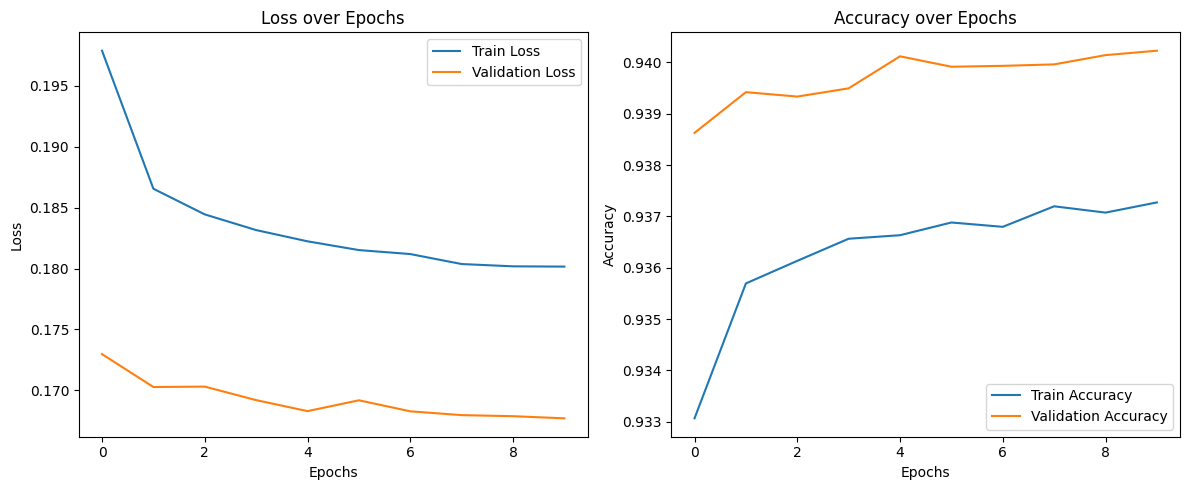

In [30]:
plot_training_history(history)

10915/10915 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


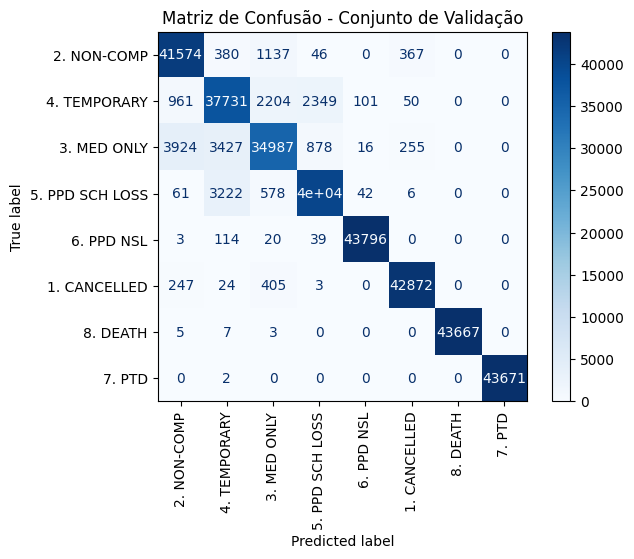

                 precision    recall  f1-score   support

    2. NON-COMP       0.89      0.96      0.92     43504
   4. TEMPORARY       0.84      0.87      0.85     43396
    3. MED ONLY       0.89      0.80      0.84     43487
5. PPD SCH LOSS       0.92      0.91      0.92     43996
     6. PPD NSL       1.00      1.00      1.00     43972
   1. CANCELLED       0.98      0.98      0.98     43551
       8. DEATH       1.00      1.00      1.00     43682
         7. PTD       1.00      1.00      1.00     43673

       accuracy                           0.94    349261
      macro avg       0.94      0.94      0.94    349261
   weighted avg       0.94      0.94      0.94    349261



In [ ]:
plot_confusion_matrix(model=nn_model_et, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    }, title="Matriz de Confusão - Conjunto de Validação"
)

In [ ]:
save_predictions_to_csv(
    model=nn_model_et,
    test_data=test_predictions_et,
    claim_ids=data_test_FS["Claim Identifier"],
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    },
    output_path="../predictions/group_40_KFold_ExtraTree_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Predições salvas em '../predictions/group_40_KFold_ExtraTree_NN_predictions.csv'.


In [52]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_ExtraTree_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP        315340
4. TEMPORARY        50592
3. MED ONLY         13473
1. CANCELLED         7892
5. PPD SCH LOSS       677
6. PPD NSL              1
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Ensemble Learning</h3>

<h5 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Weighted Averaging Ensemble</h5>


In [ ]:
#Cálculo do weight's através do desempenho
#Desempenho sem rede neuronal
f1_xgbc=0.88726
f1_rf=0.91618
f1_extratree=0.9288

#Desempenho com rede neuronal
f1_xgbc_nn=0.89
f1_rf_nn=0.93
f1_extratree_nn=0.94

total_f1 = f1_xgbc + f1_rf + f1_extratree
total_f1_nn = f1_xgbc_nn + f1_rf_nn + f1_extratree_nn

weights = [(((f1_xgbc / total_f1) + (f1_xgbc_nn / total_f1_nn)) / 2), (((f1_rf / total_f1) + (f1_rf_nn / total_f1_nn)) / 2), (((f1_extratree / total_f1) + (f1_extratree_nn / total_f1_nn)) / 2)]

Pesos Normalizados:  [0.323600490036948, 0.3361392276953199, 0.3402602822677321]


In [43]:
ensemble_test_predictions = (
    weights[0] * test_predictions_xgbc +
    weights[1] * test_predictions_rf +
    weights[2] * test_predictions_et
)

ensemble_oof_predictions = (
    weights[0] * oof_predictions_xgbc +
    weights[1] * oof_predictions_rf +
    weights[2] * oof_predictions_et
)

In [44]:
final_test_predictions = ensemble_test_predictions
final_oof_predictions = ensemble_oof_predictions

In [77]:
nn_model_weight_ensemble, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(final_oof_predictions, y_train_resampled)

history = nn_model_weight_ensemble.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_weight_ensemble, "WeightedEnsemble_NN_model")

Epoch 1/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - accuracy: 0.9203 - loss: 0.2371 - val_accuracy: 0.9308 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 2/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - accuracy: 0.9269 - loss: 0.2063 - val_accuracy: 0.9309 - val_loss: 0.1875 - learning_rate: 0.0010
Epoch 3/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.9274 - loss: 0.2035 - val_accuracy: 0.9315 - val_loss: 0.1871 - learning_rate: 0.0010
Epoch 4/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - accuracy: 0.9280 - loss: 0.2011 - val_accuracy: 0.9317 - val_loss: 0.1857 - learning_rate: 0.0010
Epoch 5/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 157s 7ms/step - accuracy: 0.9279 - loss: 0.2017 - val_accuracy: 0.9312 - val_loss: 0.1867 - learning_rate: 0.0010
Epoch 6/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 177s 8ms/step - accuracy: 0.9286 - loss: 0.1999 - val_accuracy: 0.9314 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 7/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 241s 11ms/

'../models/WeightedEnsemble_NN_model.pkl'

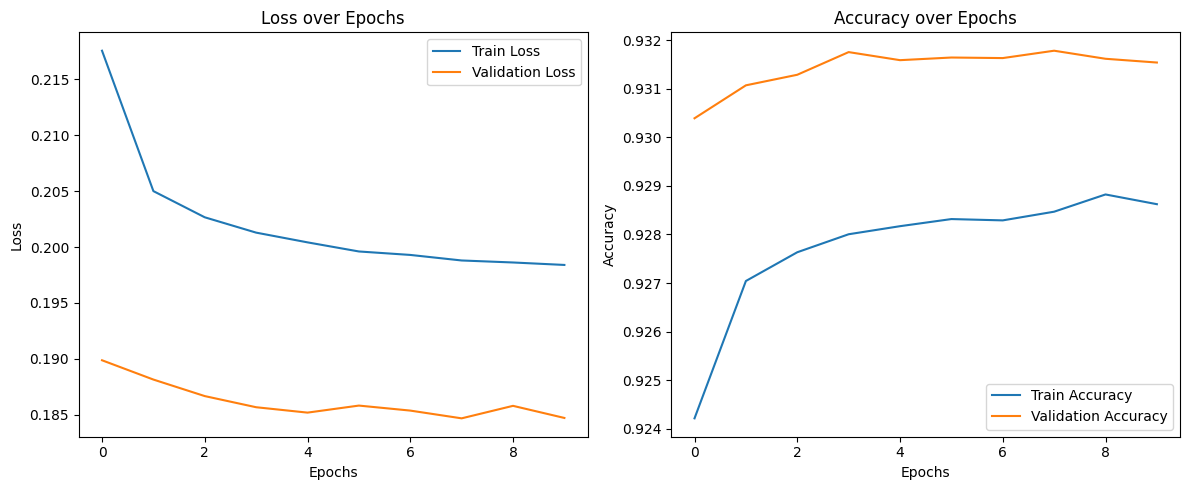

In [46]:
plot_training_history(history)

10915/10915 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


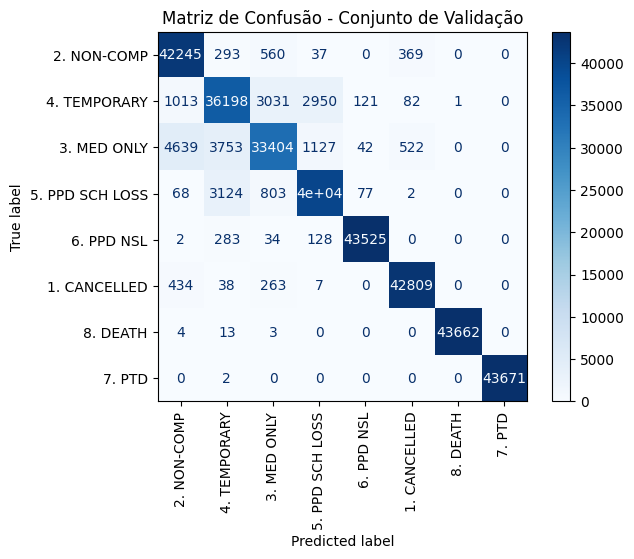

                 precision    recall  f1-score   support

    2. NON-COMP       0.87      0.97      0.92     43504
   4. TEMPORARY       0.83      0.83      0.83     43396
    3. MED ONLY       0.88      0.77      0.82     43487
5. PPD SCH LOSS       0.90      0.91      0.91     43996
     6. PPD NSL       0.99      0.99      0.99     43972
   1. CANCELLED       0.98      0.98      0.98     43551
       8. DEATH       1.00      1.00      1.00     43682
         7. PTD       1.00      1.00      1.00     43673

       accuracy                           0.93    349261
      macro avg       0.93      0.93      0.93    349261
   weighted avg       0.93      0.93      0.93    349261



In [ ]:
plot_confusion_matrix(model=nn_model_weight_ensemble, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    }, title="Matriz de Confusão - Conjunto de Validação"
)

In [ ]:
save_predictions_to_csv(
    model=nn_model_weight_ensemble,
    test_data=final_test_predictions,
    claim_ids=data_test_FS["Claim Identifier"],
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    },
    output_path="../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Predições salvas em '../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv'.


In [54]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP        317230
4. TEMPORARY        47929
3. MED ONLY         14673
1. CANCELLED         7262
5. PPD SCH LOSS       881
Name: count, dtype: int64

<h5 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Stacking Ensemble</h5>


In [60]:
X_meta_train = np.column_stack((oof_predictions_xgbc, oof_predictions_rf, oof_predictions_et))
X_meta_test = np.column_stack((test_predictions_xgbc, test_predictions_rf, test_predictions_et))

In [78]:
nn_model_stacking_ensemble, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(X_meta_train, y_train_resampled)

history = nn_model_stacking_ensemble.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_stacking_ensemble, "StackingEnsemble_NN_model")

Epoch 1/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 252s 11ms/step - accuracy: 0.9295 - loss: 0.2162 - val_accuracy: 0.9410 - val_loss: 0.1638 - learning_rate: 0.0010
Epoch 2/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 229s 10ms/step - accuracy: 0.9380 - loss: 0.1795 - val_accuracy: 0.9408 - val_loss: 0.1643 - learning_rate: 0.0010
Epoch 3/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 259s 12ms/step - accuracy: 0.9390 - loss: 0.1761 - val_accuracy: 0.9425 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 4/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 260s 12ms/step - accuracy: 0.9392 - loss: 0.1743 - val_accuracy: 0.9428 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 5/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 239s 11ms/step - accuracy: 0.9392 - loss: 0.1731 - val_accuracy: 0.9429 - val_loss: 0.1586 - learning_rate: 0.0010
Epoch 6/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 247s 11ms/step - accuracy: 0.9397 - loss: 0.1721 - val_accuracy: 0.9431 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 7/10
21829/21829 ━━━━━━━━━━━━━━━━━━━━ 22

'../models/StackingEnsemble_NN_model.pkl'

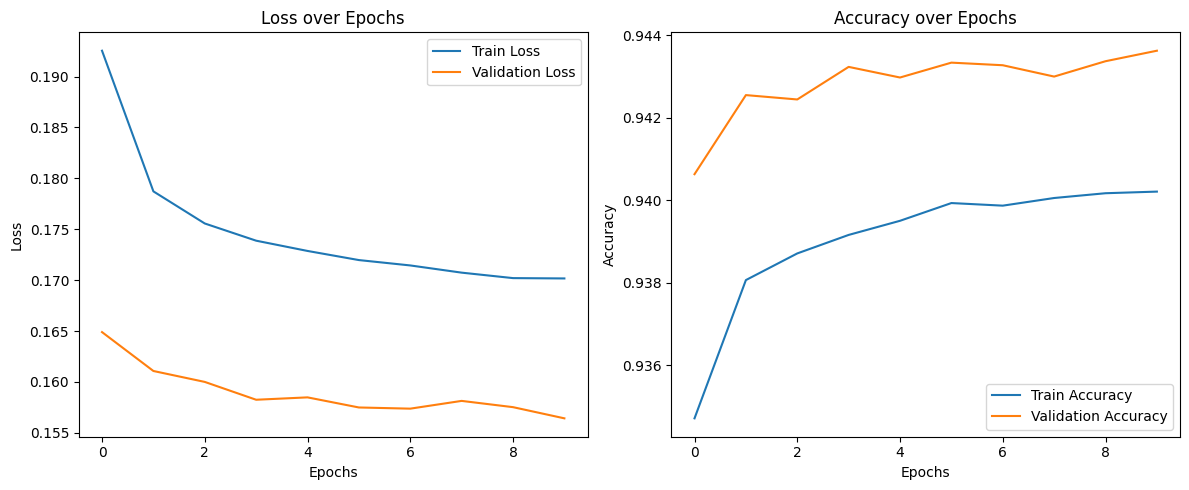

In [63]:
plot_training_history(history)

10915/10915 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


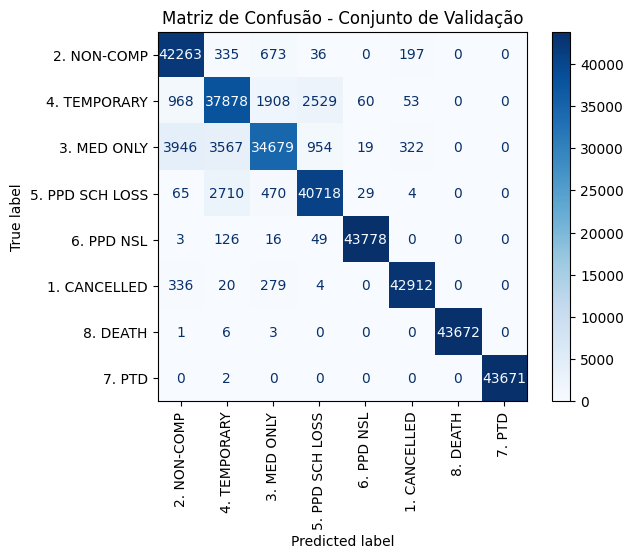

                 precision    recall  f1-score   support

    2. NON-COMP       0.89      0.97      0.93     43504
   4. TEMPORARY       0.85      0.87      0.86     43396
    3. MED ONLY       0.91      0.80      0.85     43487
5. PPD SCH LOSS       0.92      0.93      0.92     43996
     6. PPD NSL       1.00      1.00      1.00     43972
   1. CANCELLED       0.99      0.99      0.99     43551
       8. DEATH       1.00      1.00      1.00     43682
         7. PTD       1.00      1.00      1.00     43673

       accuracy                           0.94    349261
      macro avg       0.94      0.94      0.94    349261
   weighted avg       0.94      0.94      0.94    349261



In [ ]:
plot_confusion_matrix(model=nn_model_stacking_ensemble, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    }, title="Matriz de Confusão - Conjunto de Validação"
)

In [ ]:
save_predictions_to_csv(
    model=nn_model_stacking_ensemble,
    test_data=X_meta_test,
    claim_ids=data_test_FS["Claim Identifier"],
    class_mapping={
        0: '2. NON-COMP',
        1: '4. TEMPORARY',
        2: '3. MED ONLY',
        3: '5. PPD SCH LOSS',
        4: '6. PPD NSL',
        5: '1. CANCELLED',
        6: '8. DEATH',
        7: '7. PTD'
    },
    output_path="../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Predições salvas em '../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv'.


In [66]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
2. NON-COMP        325017
4. TEMPORARY        51598
3. MED ONLY          5793
1. CANCELLED         4873
5. PPD SCH LOSS       693
6. PPD NSL              1
Name: count, dtype: int64